# Question 4 - Visualisations simples #

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import matplotlib.patches as mpatches
import seaborn as sns
from visualizations import *


## 1. Graphique comparant les types de tirs de toutes les équipes dans la saison 2023-2024 ##

In [3]:
"""
Fonction pour annoter les barres dans un histogramme.
"""
def add_bar_labels(bars, type, precision=1):
    for bar in bars:
        for patch in bar.patches:
            height = patch.get_height()
            if type == 'int':
                if height > 0:  # Ne rien annoter pour les bares d'hauteur 0
                    plt.text(
                        patch.get_x() + patch.get_width() / 2,  # Centrer horizontalement sur la bare
                        height,
                        f"{int(height)}",   # Texte annoté
                        ha='center', va='bottom', fontsize=8
                    )
            if type == 'float':
                if height > 0:
                    plt.text(
                        patch.get_x() + patch.get_width() / 2,
                        height,
                        f"{round(height, precision)}",  # Texte annoté
                        ha='center', va='bottom', fontsize=8
                    )

In [4]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Obtention des données
df = get_season_df('2023-2024')                      # Données de la saison
type_frequency_df = get_shots_frequency_by_type(df)  # Fréquences pour chaque type de tir

# Trier pour une meilleure visualisation 
# (par nombre de tirs, ordre décroissant)
type_frequency_df = type_frequency_df.sort_values(by='Shot', ascending=False)

# Extraire données triées
shot_types = type_frequency_df.index.tolist()
shots_count = type_frequency_df['Shot'].tolist()
goals_count = type_frequency_df['Goal'].tolist()

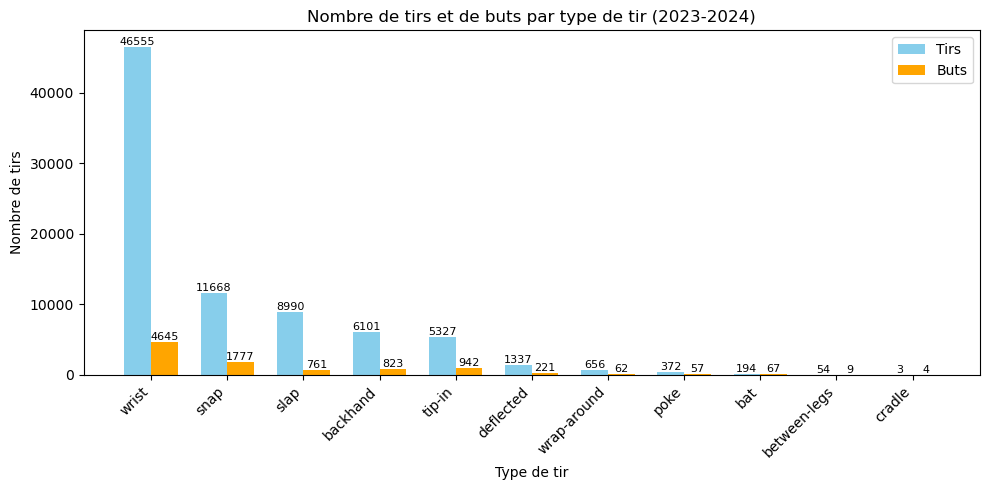

In [5]:
"""-------- GRAPHIQUE: Histogramme (barres côte à côte) --------"""

x = np.arange(len(shot_types))  # Positions des barres
width = 0.35                    # Largeur des barres

plt.figure(figsize=(10,5))

# Afficher les barres 
shots_bars = plt.bar(x - width/2, shots_count, width, label='Tirs', color='skyblue')
goals_bars = plt.bar(x + width/2, goals_count, width, label='Buts', color='orange')
add_bar_labels([shots_bars, goals_bars], 'int')  # Annoter les barres avec sa valeur

# Titre et étiquettes
plt.ylabel('Nombre de tirs')
plt.xlabel('Type de tir')
plt.title('Nombre de tirs et de buts par type de tir (2023-2024)')
plt.xticks(x, shot_types, rotation=45, ha='right')
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Calculer le nombre total de tirs (buts ou pas) pour chaque type
type_frequency_df['Total'] = type_frequency_df['Shot'] + type_frequency_df['Goal']

# Calculer la proportion des buts (#buts/#total de tirs) pour chaque type
type_frequency_df['Proportion'] = type_frequency_df['Goal'] / type_frequency_df['Total']

# Trier les valeur pour une meilleure visualisation (par proportion, ordre décroissant)
type_frequency_df = type_frequency_df.sort_values(by='Proportion', ascending=False)
shot_types = type_frequency_df.index.tolist()

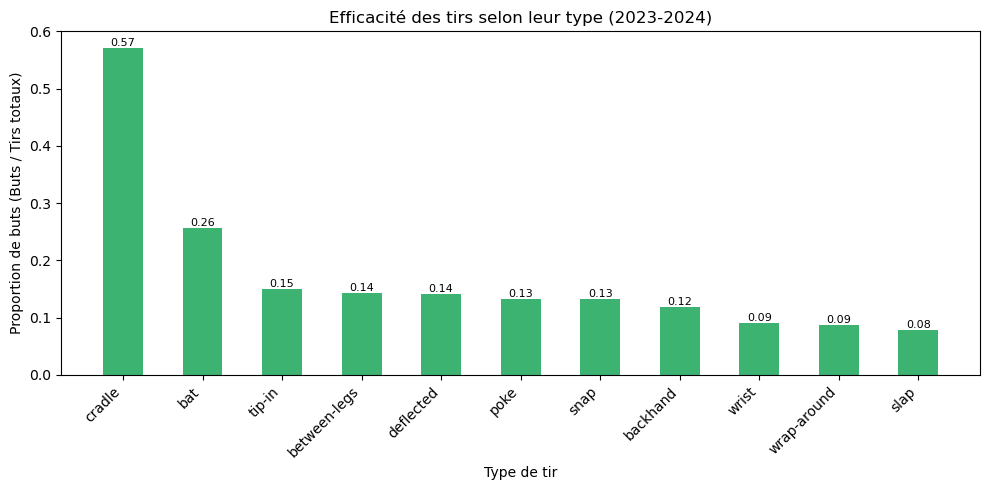

In [7]:
"""-------- GRAPHIQUE: Histogramme (proportion de #buts/#total de tirs) --------"""

plt.figure(figsize=(10,5))

# Positions des barres
x = np.arange(len(shot_types)) 

# Afficher les barres
proportion_bars = plt.bar(x, type_frequency_df['Proportion'], width= 0.5, color='mediumseagreen')
add_bar_labels([proportion_bars], 'float', 2)

# Titre et étiquettes
plt.title('Efficacité des tirs selon leur type (2023-2024)')
plt.ylabel('Proportion de buts (Buts / Tirs totaux)')
plt.xlabel('Type de tir')
plt.xticks(x, shot_types, rotation=45, ha='right')

plt.tight_layout()
plt.show()



### (b) Trouver la distance des tirs ###

* Code disponible dans le fichier '**visualizations.py**' _(voir les fontions '**get_event_distance**' et '**get_shots_distances**')_

### (a) Relation entre la distance à laquelle un tir a été effectué et la chance qu'il s'agisse d'un but ###

#### Saison 2018-2019 ####

In [8]:
rounded_df = get_shots_distances('2018-2019', rounded=True)

Empty DataFrame for game 2018010110
Empty DataFrame for game 2018010109


/Users/martin/Documents/Programacion/myWorkspace/Universidad/MILA/Automne_2025/IFT6758/IFT6758_project/ift6758/visualizations/visualizations.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


92 shots of unknown type deleted
3 distances impossible to calculate due to missing coordinates data


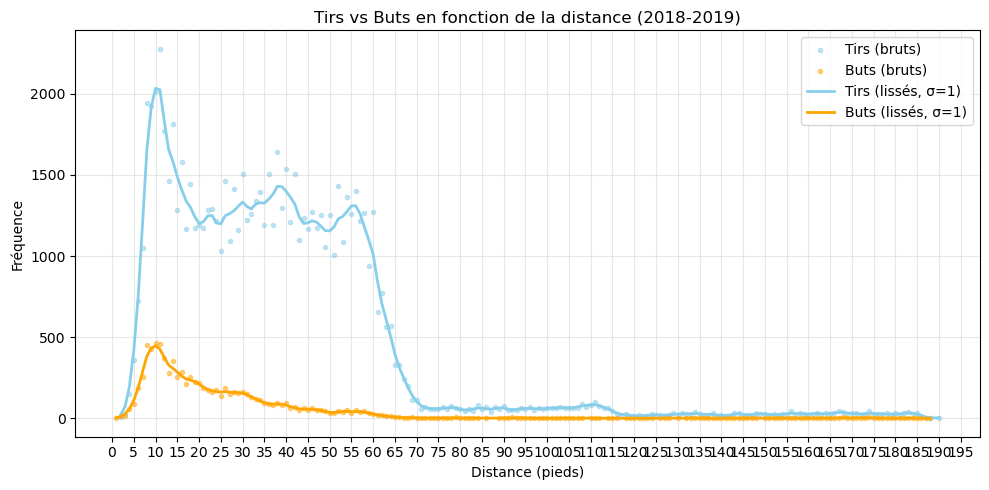

In [9]:
"""-------- GRAPHIQUE: Courbe de la fréquence d'appartition de chaque distance. --------"""

def smoothCurvePlot(df, season):
    
    # --- DONNÉES ---
    
    # Nombre de tirs manqués par distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    # Nombre de buts par distance
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    # Distances de tir (x = distance unique, y = fréquence des tirs à cette distance)
    shots_x = np.array(shots_distance_frequency.index)
    shots_y = np.array(shots_distance_frequency.values)

    # Distances des buts (x = distance unique, y = fréquence des buts à cette distance)
    goals_x = np.array(goals_distance_frequency.index)
    goals_y = np.array(goals_distance_frequency.values)
    
    
    
    # --- GRAPHIQUE ---

    plt.figure(figsize=(10, 5))

    # Lisser les fréquences avec un filtre gaussien pour atténuer les fluctuations brusques
    shots_y_smooth = gaussian_filter1d(shots_y, sigma=1)
    goals_y_smooth = gaussian_filter1d(goals_y, sigma=1)
    
    # Données brutes (points)
    plt.scatter(shots_x, shots_y, color="skyblue", alpha=0.5, marker=".", label="Tirs (bruts)")
    plt.scatter(goals_x, goals_y, color="orange", alpha=0.5, marker=".", label="Buts (bruts)")

    # Courbes lissées pour visualiser la tendance générale
    plt.plot(shots_x, shots_y_smooth, color="skyblue", label="Tirs (lissés, σ=1)", linewidth=2)
    plt.plot(goals_x, goals_y_smooth, color="orange", label="Buts (lissés, σ=1)", linewidth=2)

    # Titre et étiquettes
    plt.title(f'Tirs vs Buts en fonction de la distance ({season})')
    plt.xticks(np.arange(0, max(max(shots_x), max(goals_x)) + 10, 5))
    plt.xlabel('Distance (pieds)')
    plt.ylabel('Fréquence')
    plt.legend()
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    
smoothCurvePlot(rounded_df, '2018-2019')


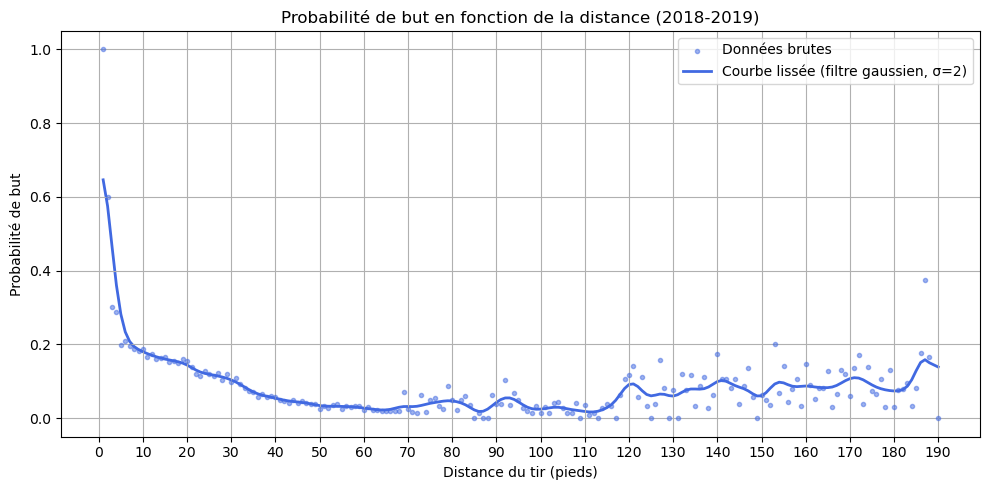

In [10]:
"""-------- GRAPHIQUE: Probabilité qu'un tir soit un but en fonction de la distance. --------"""
def goalChancePlot(df, season):
    
    # --- DONNÉES ---
    
    # Nombre de tirs manqués par distance
    shots_distance_frequency = df[df['Event Type'] == 'Shot']['Distance'].value_counts().sort_index()
    # Nombre de buts par distance
    goals_distance_frequency = df[df['Event Type'] == 'Goal']['Distance'].value_counts().sort_index()

    # Nombre total de tirs par distance (tirs + buts)
    total_shots_distance_frequency = shots_distance_frequency.add(goals_distance_frequency, fill_value=0)

    # Probabilité qu'un tir à une distance donnée devienne un but (#buts/#total de tirs --> à chaque distance)
    goal_chance_by_distance = goals_distance_frequency.divide(total_shots_distance_frequency, fill_value=0)


    # Lisser les probabilités avec un filtre gaussien pour atténuer les fluctuations brusques
    chance_smooth = gaussian_filter1d(goal_chance_by_distance.values, sigma=2)
    
    
    
    # --- GRAPHIQUE ---

    plt.figure(figsize=(10, 5))

    # Données brutes (points)
    plt.scatter(
        goal_chance_by_distance.index, 
        goal_chance_by_distance.values, 
        color='royalblue', 
        label='Données brutes', 
        zorder=2,
        marker=".",
        alpha=0.5
    )

    # Courbe lissée
    plt.plot(
        goal_chance_by_distance.index, 
        chance_smooth, 
        color='royalblue', 
        label='Courbe lissée (filtre gaussien, σ=2)', 
        linewidth=2, 
        zorder=1,
        alpha=1
    )

    # Titre et étiquettes
    plt.xticks(np.arange(0, max(goal_chance_by_distance.index) + 10, 10))
    plt.title(f'Probabilité de but en fonction de la distance ({season})')
    plt.xlabel('Distance du tir (pieds)')
    plt.ylabel('Probabilité de but')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()


goalChancePlot(rounded_df, '2018-2019')

#### Saison 2019-2020 ####

Empty DataFrame for game 2019010106
Empty DataFrame for game 2019010107


/Users/martin/Documents/Programacion/myWorkspace/Universidad/MILA/Automne_2025/IFT6758/IFT6758_project/ift6758/visualizations/visualizations.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  season_df = pd.concat(games_dfs, ignore_index=True)


82 shots of unknown type deleted
3 distances impossible to calculate due to missing coordinates data


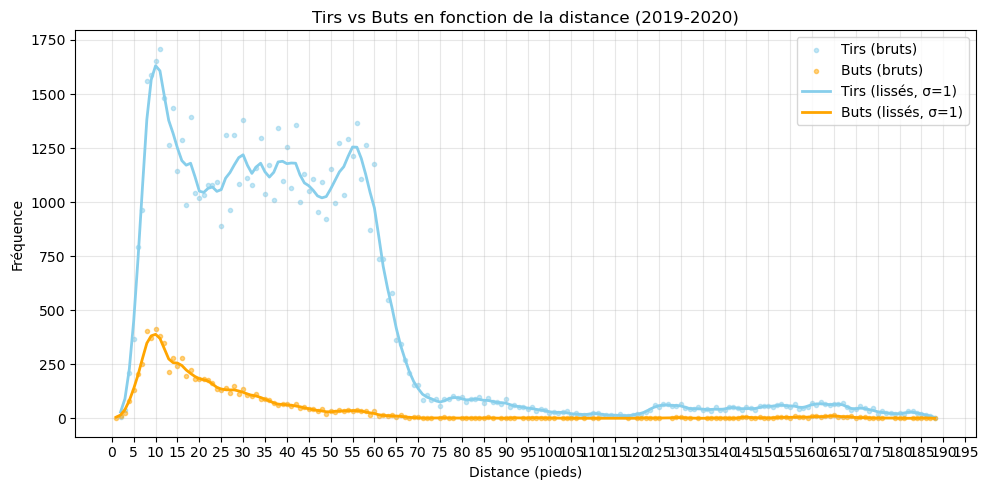

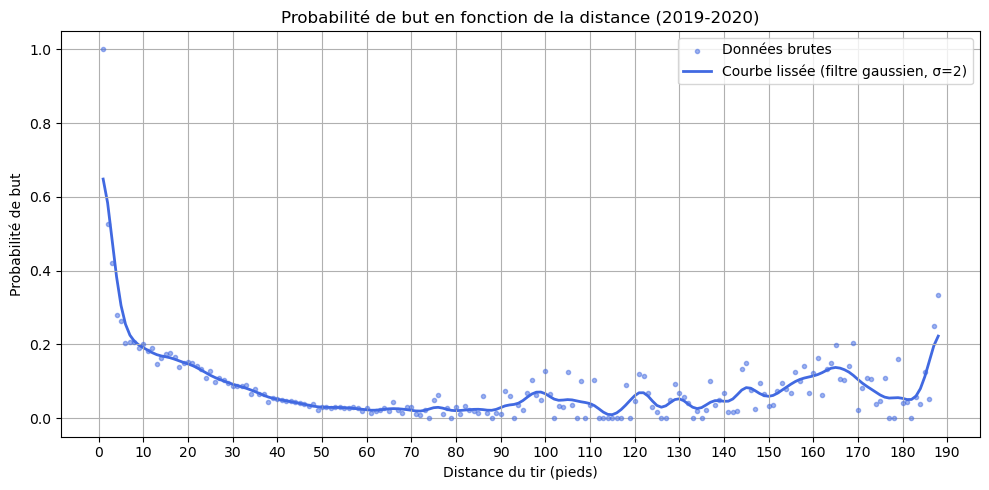

In [11]:
rounded_df = get_shots_distances('2019-2020', rounded=True)

smoothCurvePlot(rounded_df, '2019-2020')
goalChancePlot(rounded_df, '2019-2020')

#### Saison 2020-2021 ####

4 shots of unknown type deleted
0 distances impossible to calculate due to missing coordinates data


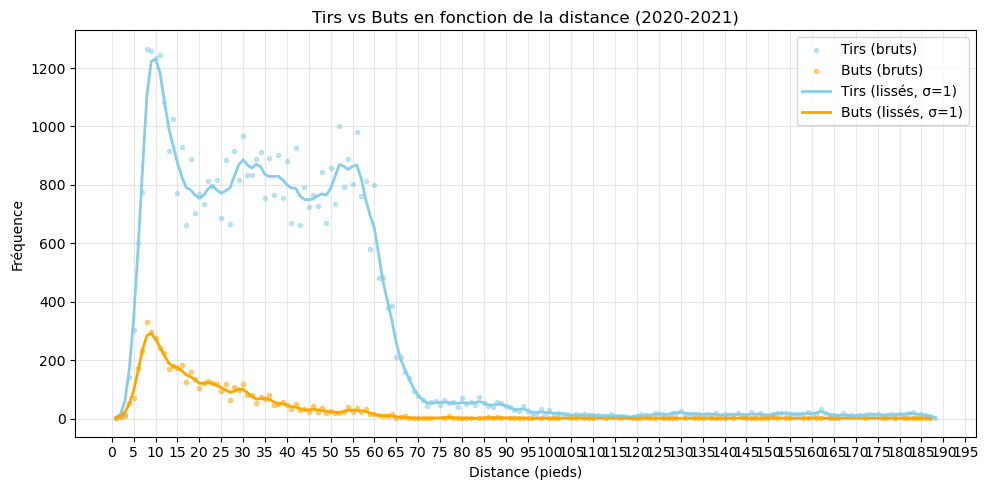

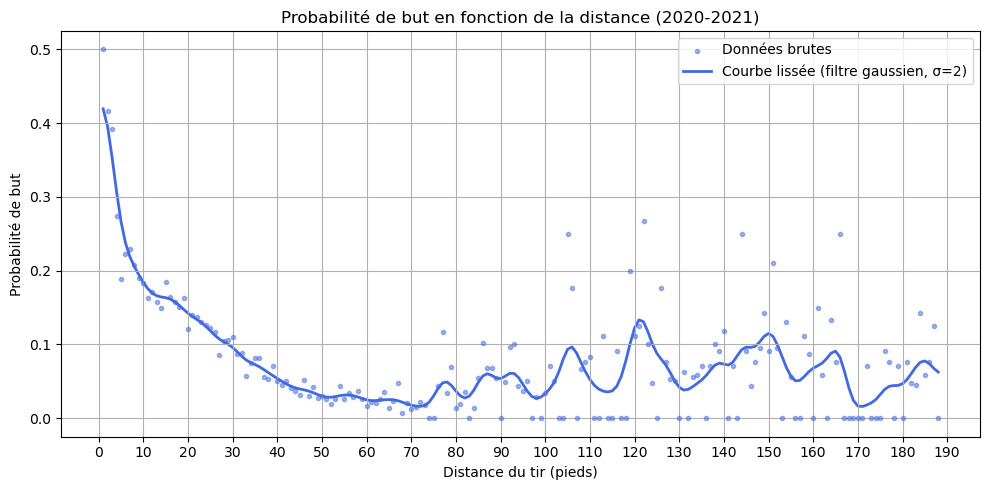

In [12]:
rounded_df = get_shots_distances('2020-2021', rounded=True)

smoothCurvePlot(rounded_df, '2020-2021')
goalChancePlot(rounded_df, '2020-2021')

## 2. Pourcentage de buts en fonction de la distance et du type de tir pour la saison 2023-2024 ##

In [13]:
"""-------- TRAITEMENT DES DONNÉES --------"""

rounded_df = get_shots_distances('2023-2024', rounded=True)


# --- TIRS RATÉS ---
shots_distance = rounded_df[rounded_df['Event Type']=='Shot']
grouped_shots_data = shots_distance.groupby(['Type of Shot', 'Distance'])
# Nombre de tirs par type et par distance
shots_distance_frequency_by_type = grouped_shots_data.size().unstack(fill_value=0)

# --- BUTS ---
goals_distance = rounded_df[rounded_df['Event Type']=='Goal']
grouped_goals_data = goals_distance.groupby(['Type of Shot', 'Distance'])
# Nombre de buts par type et par distance
goals_distance_frequency_by_type = grouped_goals_data.size().unstack(fill_value=0)


# Nombre de total tirs par type et par distance
total_shots_distance_frequency_by_type = shots_distance_frequency_by_type.add(goals_distance_frequency_by_type, fill_value=0)

# Pourcentage de buts en fonction du type et de la distance
goal_percentage_by_distance_and_type = goals_distance_frequency_by_type.divide(total_shots_distance_frequency_by_type, fill_value=0)

# Inclure toutes les distances possibles (même celles où il n’y a pas de tirs)
distances = goal_percentage_by_distance_and_type.columns
full_distances = np.arange(distances.min(), distances.max() + 1)
goal_percentage_by_distance_and_type = goal_percentage_by_distance_and_type.reindex(columns=full_distances, fill_value=np.nan)

# Réorganiser les lignes pour favoriser la visualisation
order = [
    'cradle',
    'between-legs',
    'wrap-around',
    'bat',
    'poke',
    'deflected',
    'tip-in',
    'slap',
    'backhand',
    'snap',
    'wrist'
]
goal_percentage_by_distance_and_type = goal_percentage_by_distance_and_type.reindex(order)


# Extraire les distances (colonnes) et les types de tirs (lignes)
distances = goal_percentage_by_distance_and_type.columns
shot_types = goal_percentage_by_distance_and_type.index



104 shots of unknown type deleted
0 distances impossible to calculate due to missing coordinates data


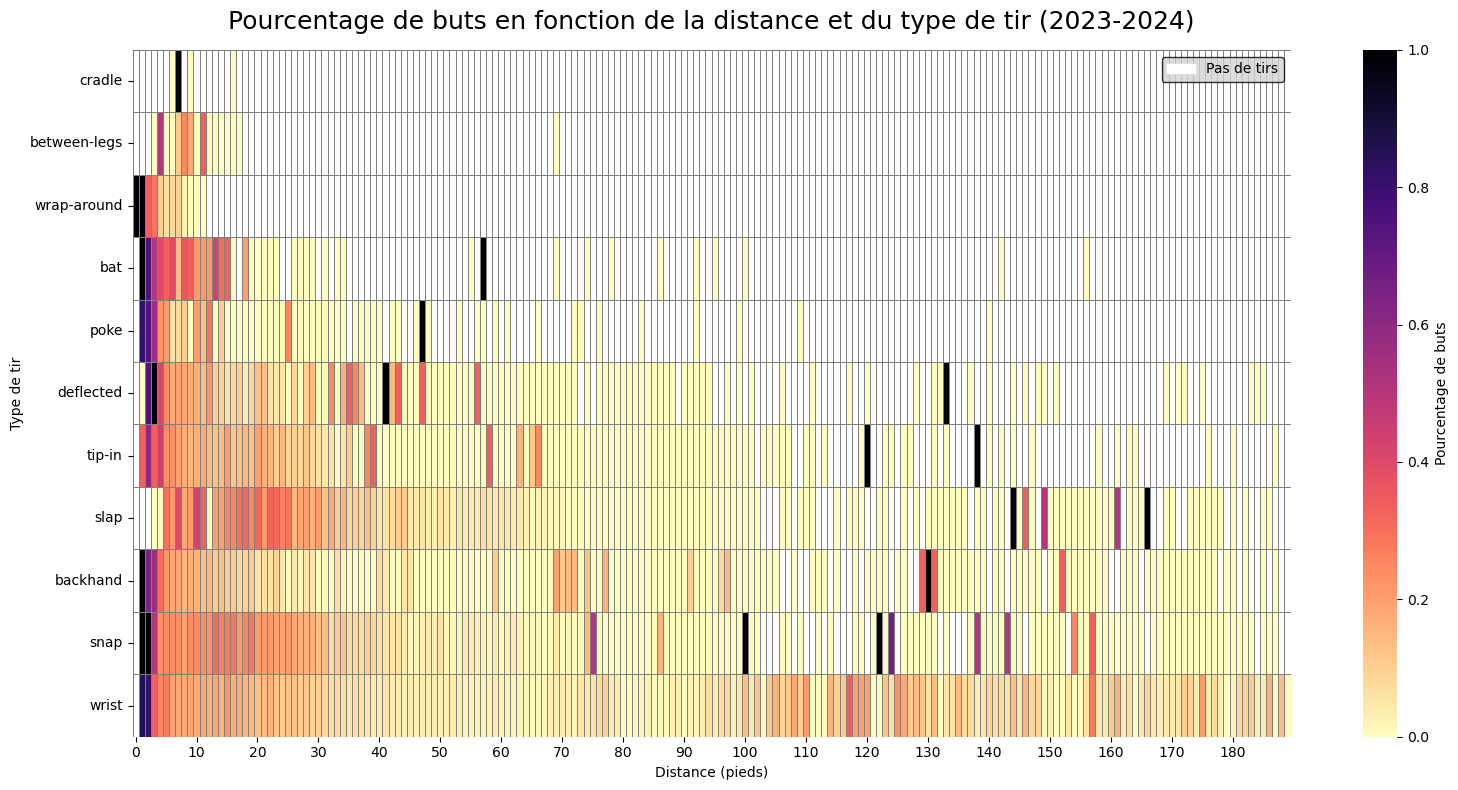

In [14]:
"""-------- GRAPHIQUE: Heatmap du pourcentage de buts en fonction de la distance et du type de tir. --------"""

plt.figure(figsize=(16, 8))

# -- Couleurs --
cmap = plt.colormaps.get_cmap("magma_r").copy()     # Couleur
mask = goal_percentage_by_distance_and_type.isna()  # Masque pour les cellules sans tirs (NaN)
cmap.set_bad(color='white')                         # Couleur pour les cellules sans tirs (NaN)


# -- Heatmap --
sns.heatmap(
    goal_percentage_by_distance_and_type,  # Données
    cmap=cmap,                             # Couleurs
    mask = mask,                           # Masquer les NaN (affichés en blanc)
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Pourcentage de buts'}  # Légende de la barre de couleurs
)


# Titre et étiquettes
plt.title('Pourcentage de buts en fonction de la distance et du type de tir (2023-2024)', fontsize=18, pad=15)
plt.xlabel('Distance (pieds)')
xticks = np.arange(0, len(distances), 10)
xtick_labels = distances[xticks]
plt.xticks(ticks=xticks + 0.5, labels=xtick_labels, rotation=0)
plt.ylabel('Type de tir')

# Légende pour les cellules sans tirs
no_data_patch = mpatches.Patch(color='white', label='Pas de tirs')
plt.legend(handles=[no_data_patch],
           loc='upper right',
           frameon=True,
           facecolor='lightgray',
           edgecolor='black')

plt.tight_layout()
plt.show()

In [15]:
"""-------- TRAITEMENT DES DONNÉES --------"""

# Extraire les distances (colonnes) et les types de tirs (lignes)
distances = total_shots_distance_frequency_by_type.columns
shot_types = total_shots_distance_frequency_by_type.index

# Réorganiser les lignes pour favoriser la visualisation
order = [
    'cradle',
    'between-legs',
    'wrap-around',
    'bat',
    'poke',
    'deflected',
    'tip-in',
    'slap',
    'backhand',
    'snap',
    'wrist'
]
total_shots_distance_frequency_by_type = total_shots_distance_frequency_by_type.reindex(order)

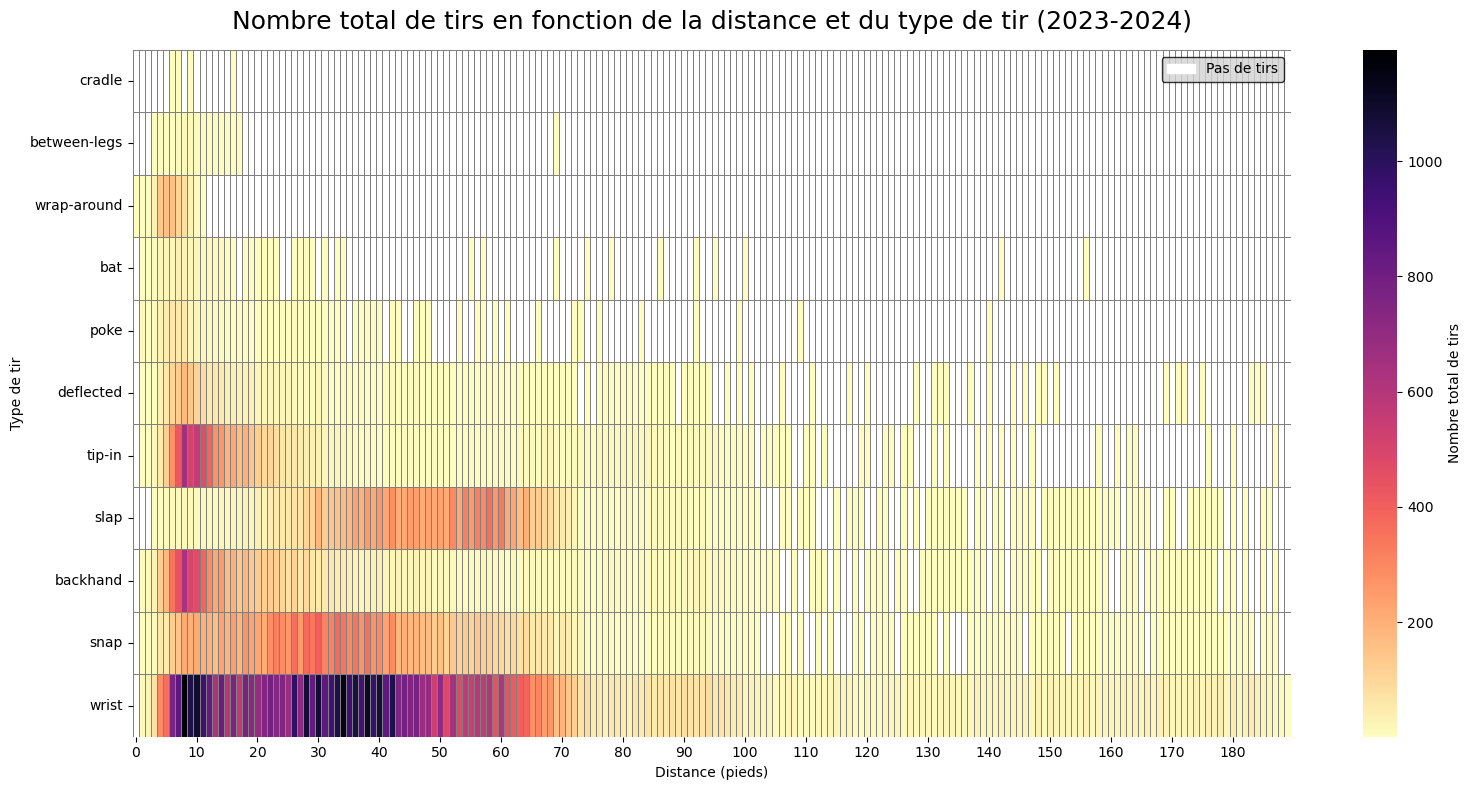

In [16]:
"""-------- GRAPHIQUE: Heatmap du nombre total de tirs en fonction de la distance et du type. --------"""

plt.figure(figsize=(16, 8))

# -- Couleurs --
cmap = plt.colormaps.get_cmap("magma_r").copy()     # Couleur
mask = total_shots_distance_frequency_by_type == 0  # Masque pour les cellules sans tirs (0)
cmap.set_bad(color='white')                         # Couleur pour les cellules sans tirs (0)

# -- Heatmap --
sns.heatmap(
    total_shots_distance_frequency_by_type,  # Données
    cmap=cmap,                               # Couleurs
    mask=mask,                               # Masquer les 0 (affichés en blanc)
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={'label': 'Nombre total de tirs'}  # Légende de la barre de couleurs
)


# Titre et étiquettes
plt.title('Nombre total de tirs en fonction de la distance et du type de tir (2023-2024)', fontsize=18, pad=15)
plt.xlabel('Distance (pieds)')
xticks = np.arange(0, len(distances), 10)
xtick_labels = distances[xticks]
plt.xticks(ticks=xticks + 0.5, labels=xtick_labels, rotation=0)
plt.ylabel('Type de tir')

# Légende pour les cellules sans tirs
no_data_patch = mpatches.Patch(color='white', label='Pas de tirs')
plt.legend(handles=[no_data_patch],
           loc='upper right',
           frameon=True,
           facecolor='lightgray',
           edgecolor='black')


plt.tight_layout()
plt.show()